In [1]:
from lmfit import Model, Parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
t0=120
T=365
national_data=pd.read_csv('..\data\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv')
new_pos=national_data['nuovi_positivi'].values[t0:T]

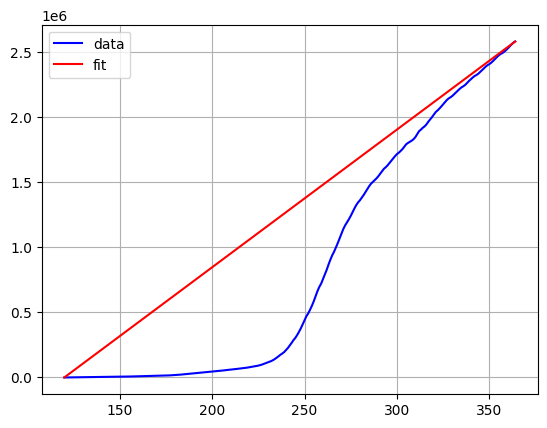

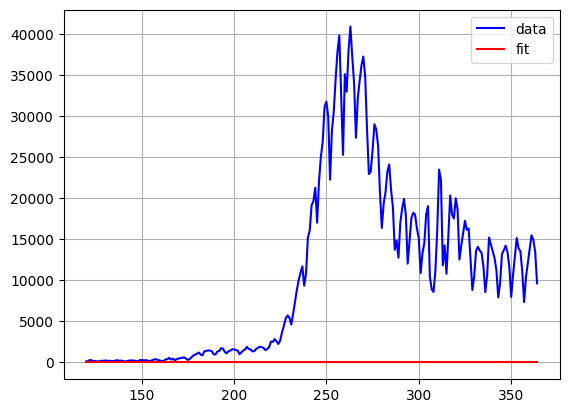

2583136.0
2583136


In [42]:
cum_pos=np.cumsum(new_pos)
d0=cum_pos[0]

# Define the Richardson bell curve function
def richardson(t, K, r, tm, nu):
    return np.int32(r*1e-2*K*1e10*np.exp(-r*1e-2*(t-tm*10e2))/((1+np.exp(-r*1e-2*(t-tm*10e2)))**(1/(nu*1e-5))*(1+np.exp(-r*1e-2*(t-tm*10e2)))))

# Fit on the S curve
def cum_richardson(t, K, r, tm, nu, d):
    return np.cumsum(richardson(t, K, r, tm, nu)) + d + (cum_pos[-1]-d-np.cumsum(richardson(t, K, r, tm, nu))[-1])/(t[-1]-t[0])*(t-t[0])



t= np.arange(t0,T)

# create model
fmodel = Model(cum_richardson)
# create parameters -- these are named from the function arguments --
# giving initial values
params = fmodel.make_params(K=56.88456679,  r=6.10297694, tm=-1.32496724,  nu=4.13305862, d=d0)
fmodel.set_param_hint('K',min=0)
fmodel.set_param_hint('r', min=0)
fmodel.set_param_hint('nu', min=0)

# fix d:
params['d'].vary = False

# fit the model
result = fmodel.fit(cum_pos, params, t=t)
sigma = result.eval_uncertainty()

plt.figure()
plt.plot(t, cum_pos, 'b-', label='data')
plt.plot(t, result.best_fit, 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, new_pos, 'b-', label='data')
plt.plot(t, richardson(t, result.params['K'].value, result.params['r'].value, result.params['tm'].value, result.params['nu'].value), 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

print(result.best_fit[-1])
print(cum_pos[-1])


more curves

In [4]:
from lmfit import Parameters

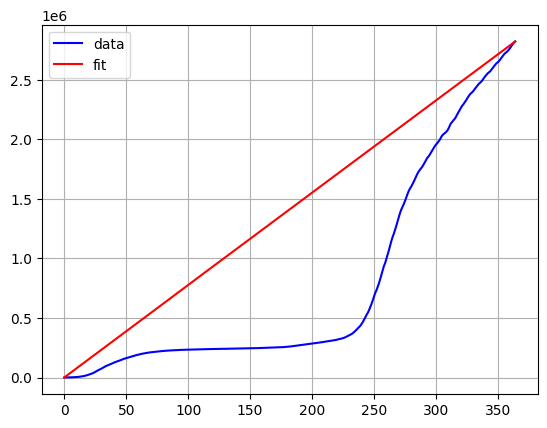

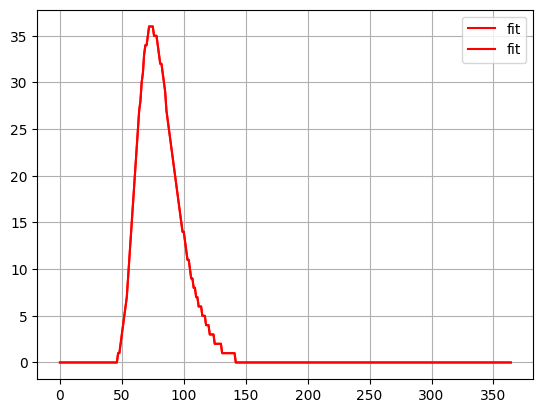

2822247.0
2822247
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
K0   5.688e+09        0      inf     None     True     None     None
K1   5.688e+09        0      inf     None     True     None     None
d0        221     -inf      inf     None    False     None     None
d1          0     -inf      inf     None    False     None     None
n           2     -inf      inf     None    False     None     None
nu0  4.133e-05        0      inf     None     True     None     None
nu1  4.133e-05        0      inf     None     True     None     None
r0    0.06103        0      inf     None     True     None     None
r1    0.06103        0      inf     None     True     None     None
tm0    -132.5     -inf      inf     None     True     None     None
tm1    -132.5     -inf      inf     None     True     None     None
--------------------------
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
K0   2.616e+08        0      inf     None     True     None  

In [30]:
t0=0
T=365
national_data=pd.read_csv('..\data\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv')
new_pos=national_data['nuovi_positivi'].values[t0:T]

cum_pos=np.cumsum(new_pos)
d0=cum_pos[0]
n_curves = 2

####functions
def make_param_0(n = 1):
    params = Parameters()
    params.add("n", n, vary = False)

    for i in range(n):
        params.add(f"K{i}", 5.68845650e+09, min=0)
        params.add(f"r{i}", 6.10297694e-02, min=0)
        params.add(f"tm{i}", -1.32496724e+02)
        params.add(f"nu{i}", 4.13305862e-05, min=0)
        params.add(f"d{i}", 0, vary = False)

    params['d0'].value = d0

    return params

# Define the Richardson bell curve function
def richardson(t, K, r, tm, nu):
    return np.int32(r*K*np.exp(-r*(t-tm))/((1+np.exp(-r*(t-tm)))**(1/nu)*(1+np.exp(-r*(t-tm)))))

# Fit on the S curve
def cum_richardson(t, K, r, tm, nu, d):
    return np.cumsum(richardson(t, K, r, tm, nu)) + d # + (cum_pos[-1]-d-np.cumsum(richardson(t, K, r, tm, nu))[-1])/(t[-1]-t[0])*(t-t[0])


def cum_richardson_n(t, n, **kwargs):
    sum = np.zeros(np.shape(t)[0])
    for i in range(n):
        sum += cum_richardson(t, K = kwargs[f"K{i}"], 
                             r = kwargs[f"r{i}"], tm = kwargs[f"tm{i}"], 
                             nu = kwargs[f"nu{i}"], d = kwargs[f"d{i}"])
    return sum + (cum_pos[-1]-sum[-1])/(t[-1]-t[0])*(t-t[0])

################

t = np.arange(t0,T)

# create model
fmodel = Model(cum_richardson_n)
# create parameters -- these are named from the function arguments --
# giving initial values
params = make_param_0(n = n_curves)

# fit the model
result = fmodel.fit(cum_pos, params, t=t, max_nfev=100000)
sigma = result.eval_uncertainty()

plt.figure()
plt.plot(t, cum_pos, 'b-', label='data')
plt.plot(t, result.best_fit, 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
#plt.plot(t, new_pos, 'b-', label='data')
for i in range(n_curves):
    plt.plot(t, richardson(t, result.params[f'K{i}'].value, result.params[f'r{i}'].value, result.params[f'tm{i}'].value, result.params[f'nu{i}'].value), 'r-', label='fit')
plt.legend()
plt.grid(True)
plt.show()

print(result.best_fit[-1])
print(cum_pos[-1])

params.pretty_print()
print('--------------------------')
result.params.pretty_print()
print(result.fit_report())

In [6]:
# def make_dict_params(n = 1):
#     D_param0 = {}
#     for i in range(n):
#         D_param0 |= {f"K{i}" : 5.68845650e+09,  
#             f"r{i}" : 6.10297694e-02,
#             f"tm{i}" : -1.32496724e+02,
#             f"nu{i}" : 4.13305862e-05,
#             f"d{i}" : d0}

#     return D_param0

# dict0 = make_dict_params(2)
# print(dict0)

# cum_richardson_n(t, n=2, **dict0)